In [1]:
from numpy_ringbuffer import RingBuffer

REAPLAY_MEMORY_SIZE = 10000 # should be 1000000
REPLAY_START_SIZE = 500 # should be 50000

In [2]:
INIT_EPS = 1
END_EPS = 0.1
FINAL_EXPLORATION_FRAME = REAPLAY_MEMORY_SIZE

DISCOUNT_FACTOR = 0.99

In [3]:
import gym
import numpy as np
import tensorflow as tf
from random import sample
from tensorflow.keras import layers, Model
from time import time
from timeit import timeit
from matplotlib import pyplot as plt
from tqdm import tqdm

import utils

print(tf.config.list_physical_devices('GPU')[0])

env = gym.make("ALE/Breakout-v5")

N_ACTIONS = env.action_space.n
OBS_RANGE = int(env.observation_space.high_repr) - int(env.observation_space.low_repr)
OBS_SHAPE = env.observation_space.shape
# SKIP_FRAMES = [2, 3, 4] # possible addition --> skip randomly 2/3/4 frames instead of always 4
N_INPUT_FRAMES = 4

BATCH_SIZE = 32

input_shape = [*OBS_SHAPE]
input_shape[-1] *= N_INPUT_FRAMES

experience_buffer = [
    RingBuffer(capacity=REAPLAY_MEMORY_SIZE, dtype= (float, input_shape)),     # observation at time t
    RingBuffer(capacity=REAPLAY_MEMORY_SIZE),                                   # action at time t
    RingBuffer(capacity=REAPLAY_MEMORY_SIZE),                                   # reward at time t
    RingBuffer(capacity=REAPLAY_MEMORY_SIZE, dtype= (float, input_shape)),     # observation at time t+1
    RingBuffer(capacity=REAPLAY_MEMORY_SIZE)                                    # is done (for target computation)
    ]

print(len(experience_buffer))

obs = np.zeros(input_shape)
target = np.zeros(BATCH_SIZE)

model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=True,
    weights=None,
    input_shape=input_shape,
    classes=N_ACTIONS,
    classifier_activation='softmax'
)

target_model = tf.keras.models.clone_model(model)
# target_model_weights = model.save_weights("./target_model_weights")
TARGET_MODEL_UPDATE_FREQUENCY = 1000
tr_weights = model.trainable_weights

total_params = sum([np.prod(w.get_shape().as_list()) for w in tr_weights])
print(total_params)

opt = tf.keras.optimizers.Adam(learning_rate= 2e-4)


/home/marcello/github/AtariGym/env/lib/python3.8/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/marcello/github/AtariGym/env/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/home/marcello/github/AtariGym/env/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/home/marcello/github/AtariGym/env/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_imag

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
5


2022-04-07 14:30:34.278147: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-07 14:30:34.279432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 14:30:34.279754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 14:30:34.279869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

4015264


In [4]:
def preprocess_observation(obs):
    return obs / OBS_RANGE

In [5]:
def simulate(env, action): # big but finite MDP
    i = 0
    k_reward = 0
    done = 0

    while i < N_INPUT_FRAMES and not done:

        observation, reward, done, info = env.step(action)
        obs[:, :, i:i+3] = observation # simply concatenate observations --> each is 3 channels deep
        i += 1
        k_reward += reward

    p_obs = preprocess_observation(obs)
    return p_obs, k_reward, done

In [6]:
# @tf.function
def process_gradient(g):
    return tf.math.maximum(1., tf.math.minimum(-1., g))

In [7]:
def add_to_buffer(buffer, tuple):
    for i, elem in enumerate(tuple):
        buffer[i].append(elem)

RETURN_LIST = [ # initialization for faster processing
    tf.Variable(tf.zeros(shape=(BATCH_SIZE, 210, 160, 12))),
    tf.Variable(tf.zeros(shape=(BATCH_SIZE,))),
    tf.Variable(tf.zeros(shape=(BATCH_SIZE,))),
    tf.Variable(tf.zeros(shape=(BATCH_SIZE, 210, 160, 12))),
    tf.Variable(tf.zeros(shape=(BATCH_SIZE,)))
]

def sample_from_buffer(buffer, sample_size):
    idx = sample(range(len(buffer[0])), sample_size)
    for i in range(len(buffer)):
        RETURN_LIST[i]= tf.stack(buffer[i][idx])
    # return [tf.stack(buffer[i][idx]) for i in range(sample_size)]
    return RETURN_LIST

  0%|          | 1000/1000000 [03:42<117:43:44,  2.36it/s]

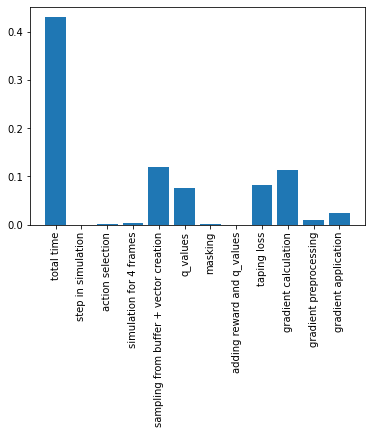

eps:  0.95509 mean episode frames:  35.714285714285715


  0%|          | 1501/1000000 [07:23<183:38:10,  1.51it/s]

Total frame 1500 updating weights


  0%|          | 2000/1000000 [11:01<116:02:33,  2.39it/s]

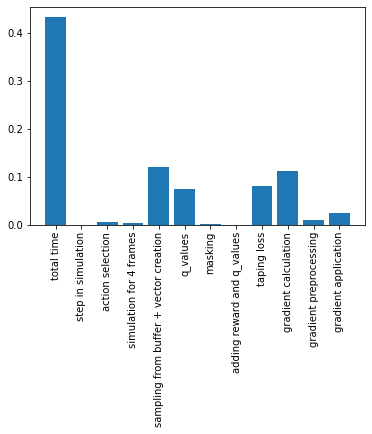

eps:  0.8650899999999999 mean episode frames:  34.48275862068966


  0%|          | 2501/1000000 [14:44<180:31:54,  1.53it/s]

Total frame 2500 updating weights


  0%|          | 3000/1000000 [18:25<122:57:28,  2.25it/s]

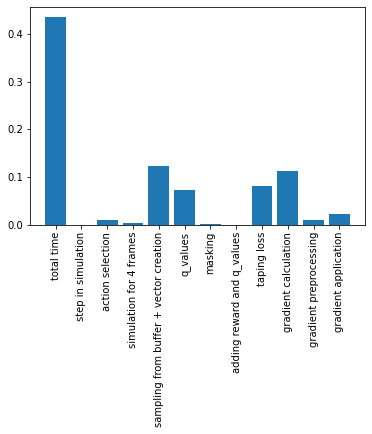

eps:  0.77509 mean episode frames:  34.09090909090909


  0%|          | 3065/1000000 [18:53<137:04:50,  2.02it/s]

KeyboardInterrupt: 

In [8]:
times = {
      "total time": [],
      "step in simulation": [],
      "action selection": [],
      "simulation for 4 frames": [],
      "sampling from buffer + vector creation": [],
      "q_values": [],
      "masking": [],
      "adding reward and q_values": [],
      "taping loss": [],
      "gradient calculation": [],
      "gradient preprocessing": [],
      "gradient application": []
}
MAX_TOTAL_FRAMES = int(1e6)
total_frames = 0
target_model_update_frames = 0
pbar = tqdm(total = MAX_TOTAL_FRAMES)

episode_frame_counter = 0
n_episodes = 0

observation, info = env.reset(seed=42, return_info=True)

while total_frames < MAX_TOTAL_FRAMES:  # episodes
      
      action = env.action_space.sample() # how do you solve the first frame? which action do you choose? (since the obs are 4 frames concat)
      
      n_episodes += 1
      episode_frame_counter = 0
      while episode_frame_counter < 1000: # max n° of frames per episode

            episode_frame_counter += 1
            total_frames += 1
            pbar.update(1)

            if total_frames%1000 == 0:
                  plt.xticks(rotation="vertical")
                  plt.bar(times.keys(), [sum(x)/len(x) if len(x)!=0 else 0 for x in times.values()])
                  plt.show()
                  print("eps: ", eps, "mean episode frames: ", total_frames/n_episodes)
                  

            obs, reward, done = simulate(env, action) # to create the starting point for the episode (first observation is 4 frames)
            p_obs = preprocess_observation(obs)
            
            if total_frames < REPLAY_START_SIZE:
                  # random sampling the first "REPLAY_START_SIZE" steps
                  action = env.action_space.sample()
                  next_p_obs, reward, is_end_state = simulate(env, action)
                  add_to_buffer(experience_buffer, (p_obs, action, reward, next_p_obs, is_end_state))

            else:
                  total_time = time()
                  eps = utils.calculate_eps(total_frames, REPLAY_START_SIZE, FINAL_EXPLORATION_FRAME, INIT_EPS, END_EPS)
                  # policy
                  
                  t = time()
                  action = utils.eps_greedy_policy(eps, env, model, p_obs)
                  times["action selection"].append(time()-t)

                  # next observation
                  t = time()
                  next_p_obs, reward, is_end_state = simulate(env, action)
                  times["simulation for 4 frames"].append(time()-t)

                  # append observation, action, reward, next_observation and "done" into the experience buffer
                  add_to_buffer(experience_buffer, (p_obs, action, reward, next_p_obs, is_end_state)) # RingBuffer automatically pops from opposite side if maxlen is surpassed

                  # sample BATCH_SIZE elements from the buffer
                  t = time()
                  batched_old_observation, batched_action, batched_reward, batched_new_observation, batched_done = sample_from_buffer(experience_buffer, BATCH_SIZE) # for the training instead batch is 32
                  times["sampling from buffer + vector creation"].append(time()-t)

                  ### SHOULD be faster but isn't
                  # t = time()
                  # batched_new_observation_not_done = tf.boolean_mask(batched_new_observation, tf.math.logical_not(batched_done))
                  # t1 = time()
                  # batch_q_values_not_done = tf.math.reduce_max(target_model(batched_new_observation_not_done), axis=1)
                  # t2 = time() - t1
                  # batch_q_values = tf.stack([q_value if not transition[4] else 0 for transition, q_value in zip(transition_batch, batch_q_values_not_done.numpy())])
                  # print("new method: ", time()-t)
                  # print("target model with batch: ", batched_new_observation_not_done.shape, "time", t2)

                  # compute the max q_values for all new_observations
                  t = time()
                  batch_q_values = tf.math.reduce_max(target_model(batched_new_observation), axis=1)
                  times["q_values"].append(time()-t)

                  t= time()
                  # select only the ones in which the model is not in its final state, because the value of the final state's target is simply the final reward
                  masked_batch_q_values = tf.multiply(tf.multiply(batch_q_values, tf.cast(batched_done, tf.float32)), DISCOUNT_FACTOR)
                  times["masking"].append(time()-t)

                  t = time()
                  # compute the target for each transition: reward + possibly the max q_value
                  target = tf.math.add(masked_batch_q_values, tf.cast(batched_reward, tf.float32))
                  # now let's train the network: we need to update the weights
                  times["adding reward and q_values"].append(time()-t)

                  t = time()
                  with tf.GradientTape() as tape:
                        # tape.watch(model.tr_w)
                        # the loss function is simply MSE
                        # loss = tf.keras.losses.MeanSquaredError(
                        #       target, 
                        #       tf.math.reduce_max( model(batched_old_observation), axis=1 )
                        # )

                        loss = tf.math.reduce_sum(
                              tf.math.square( 
                                    tf.subtract(
                                          target, 
                                          tf.math.reduce_max( model(batched_old_observation), axis=1 )
                                    )  
                              )
                        )
                  times["taping loss"].append(time()-t)

                  t = time()
                  grads = tape.gradient(loss, tr_weights)
                  times["gradient calculation"].append(time()-t)

                  t = time()
                  # clip the gradients in [-1;+1]
                  processed_grads = [process_gradient(g) for g in grads]
                  times["gradient preprocessing"].append(time()-t)

                  t = time()
                  opt.apply_gradients(zip(processed_grads, tr_weights))
                  times["gradient application"].append(time()-t)

                  if target_model_update_frames == TARGET_MODEL_UPDATE_FREQUENCY:
                        target_model_update_frames = 0
                        model.save_weights("./weights/update_weights")
                        target_model.load_weights("./weights/update_weights")
                        print("Total frame", total_frames, "updating weights")
                  target_model_update_frames += 1

                  times["total time"].append(time()-total_time)

            if is_end_state:
                 observation, info = env.reset(return_info=True)
                 break

      if episode_frame_counter >= 1000:
            observation, info = env.reset(return_info=True)
            print("episode too long!")
env.close()